<a href="https://colab.research.google.com/github/leinaxd/NOTES/blob/main/digital_image_processing/notebooks/12a_thresholding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Thresholding
```
Author: Eichenbaum Daniel
Email: eichenbaum.daniel@gmail.com
```

This is a practical demo to understand the theory behind:
  ```
DIP Lecture 12: Thresholding ¬Rich Radke
  https://www.youtube.com/watch?v=ojapO75FV38&list=PLuh62Q4Sv7BUf60vkjePfcOQc8sHxmnDX&index=12
  
Textbook: 10.3-10.4 Digital Image Processing
  Gonzalez and Woods, 3rd ed.  
  https://www.amazon.com/-/es/Rafael-Gonzalez/dp/0133356728  
  ```

(1200, 1600, 3)


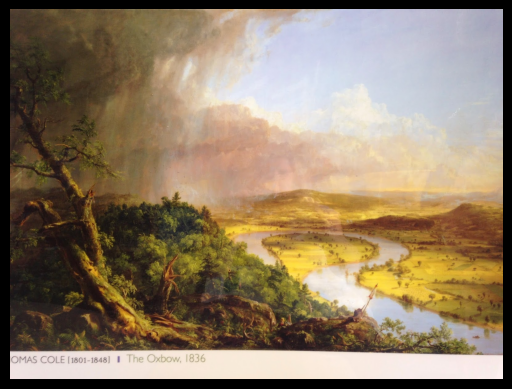

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
plt.style.use('dark_background')


url = "https://github.com/leinaxd/NOTES/raw/main/digital_image_processing/notebooks/background.jpg"
with urllib.request.urlopen(url) as url:
    img = plt.imread(url, format='jpg')
plt.imshow(img)
plt.axis('off')

print(img.shape)

r_mask = img[:, :, 0]
g_mask = img[:, :, 1]
b_mask = img[:, :, 2]

#turn image to gray
g_img = r_mask*0.2989 + g_mask*0.5870 + b_mask*0.1140
u_img = np.uint8(g_img)

# Image segmentation:

## Thresholding

Background separation

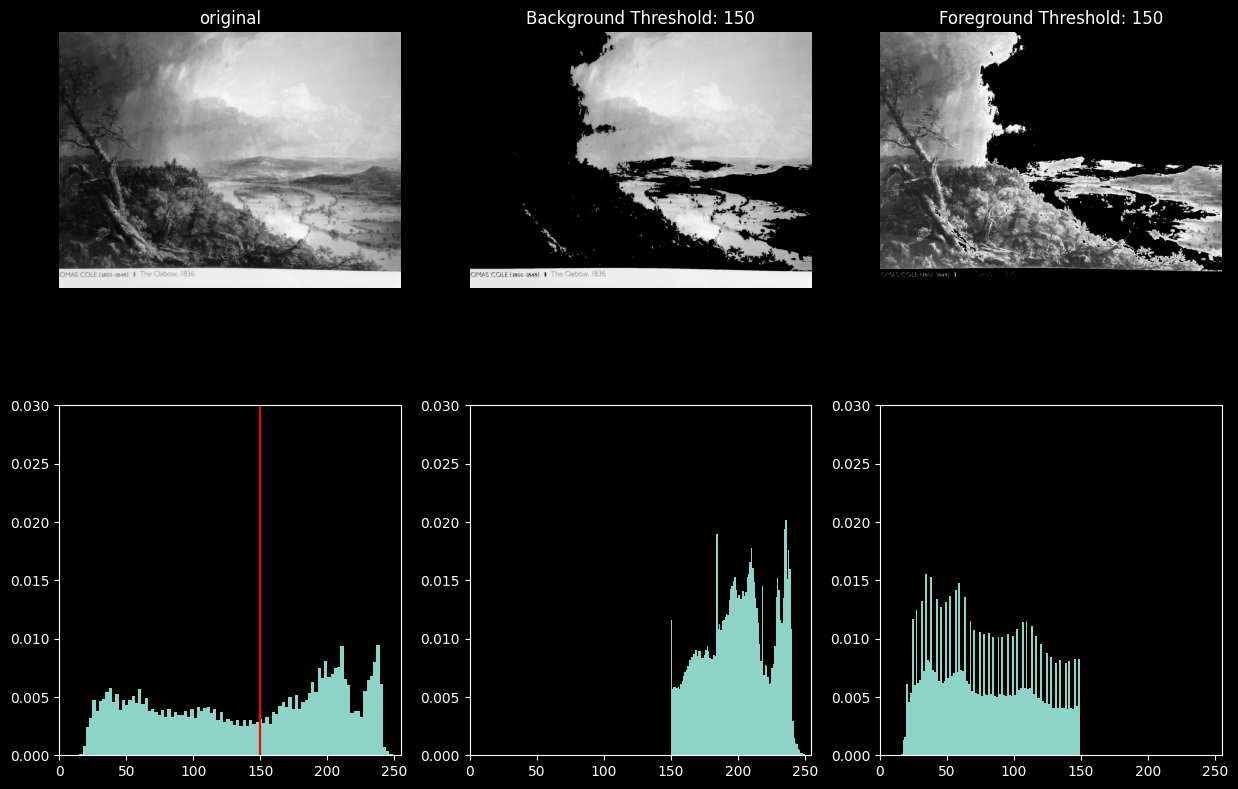

In [26]:
nbins = 100 #@param{'type':'integer'}
th = 150 #@param {'type':'integer'}
ylim = 0.03 #@param {'type':'number'}
fig, ax = plt.subplots(2,3, figsize=(15,10))

ax[0][0].imshow(g_img, cmap='gray')
ax[0][0].axis('off')
ax[0][0].set_title('original');
ax[1][0].hist(g_img.flatten(), bins=nbins, density=True);
ax[1][0].axvline(th, color='r')
ax[1][0].set_xlim([0, 255]);
ax[1][0].set_ylim([0, ylim]);

im = (g_img > th)*g_img
im = np.uint8(im)
f_im = im.flatten()

ax[0][1].imshow(im, cmap='gray')
ax[0][1].set_title(f'Background Threshold: {th}');
ax[0][1].axis('off');
ax[1][1].hist(f_im[f_im.nonzero()], bins=nbins, density=True);
ax[1][1].set_xlim([0, 255]);
ax[1][1].set_ylim([0, ylim]);

im = (g_img <= th)*g_img
im = np.uint8(im)
f_im = im.flatten()

ax[0][2].imshow(im, cmap='gray')
ax[0][2].set_title(f'Foreground Threshold: {th}');
ax[0][2].axis('off');
ax[1][2].hist(f_im[f_im.nonzero()], bins=nbins, density=True)
ax[1][2].set_xlim([0, 255]);
ax[1][2].set_ylim([0, ylim]);

Synthetic image

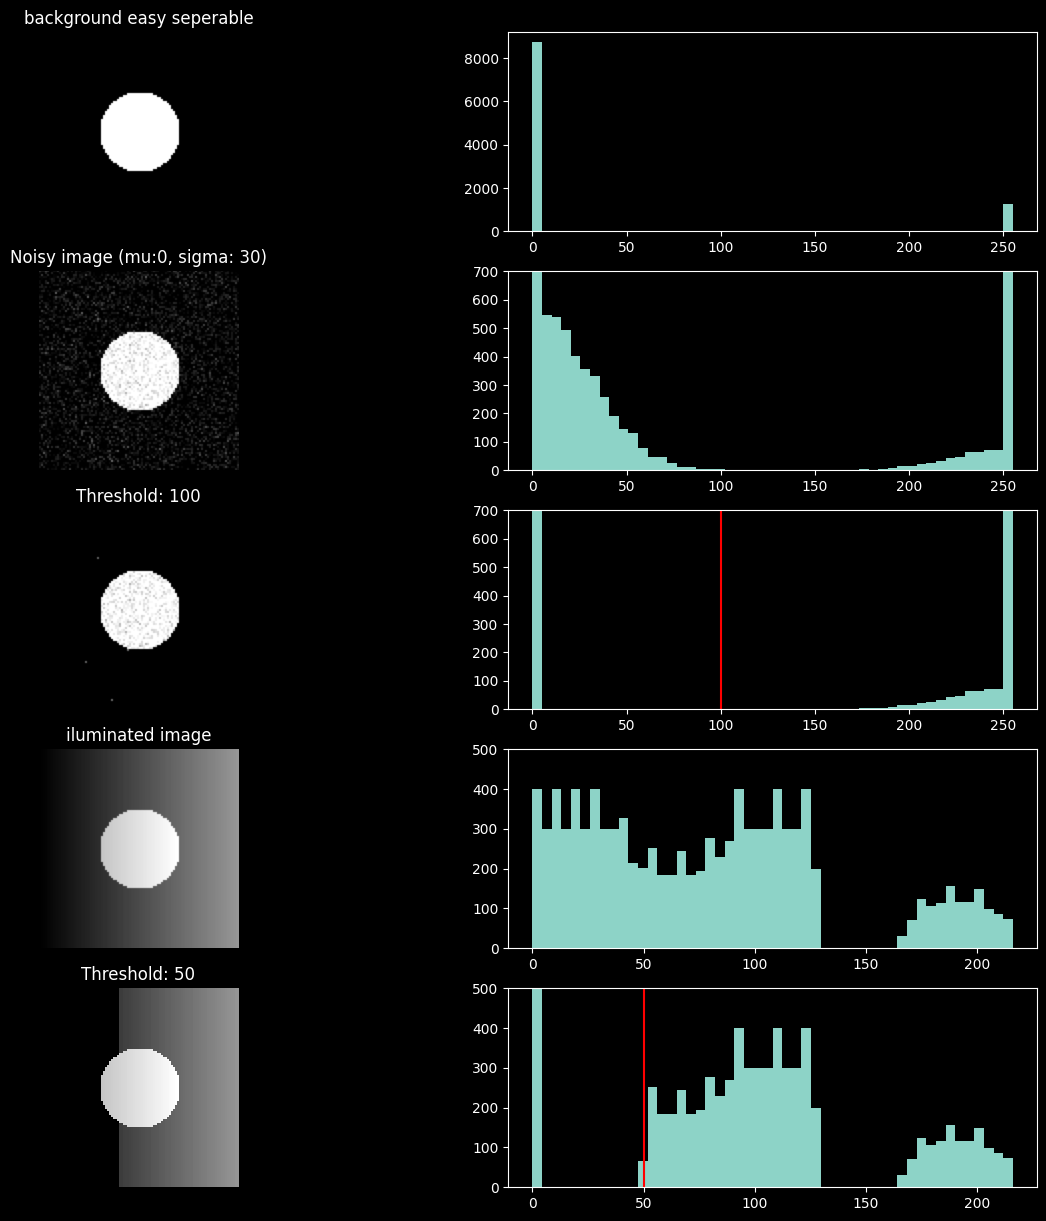

In [38]:
nbins = 50
x, y = np.meshgrid(np.arange(-50,50), np.arange(-50,50))

im  = (x*x + y*y < 400)*255
im = np.uint8(im)

fig, ax = plt.subplots(5,2, figsize=(15,15))

ax[0][0].imshow(im, cmap='gray')
ax[0][0].set_title('background easy seperable');
ax[0][0].axis('off');
ax[0][1].hist(im.flatten(), bins=nbins);

mu, sigma = 0,30
noise = np.random.normal(mu, sigma, im.shape)

im  = im+noise
im  = np.clip(im, 0, 255)
im = np.uint8(im)

ax[1][0].imshow(im, cmap='gray')
ax[1][0].set_title(f'Noisy image (mu:{0}, sigma: {30})');
ax[1][0].axis('off');
ax[1][1].hist(im.flatten(), bins=nbins);
ax[1][1].set_ylim([0, 700]);

th = 100
im = (im>th)*im
im = np.uint8(im)

ax[2][0].imshow(im, cmap='gray')
ax[2][0].set_title(f'Threshold: {th}');
ax[2][0].axis('off');
ax[2][1].hist(im.flatten(), bins=nbins);
ax[2][1].axvline(th, color='r')
ax[2][1].set_ylim([0, 700]);


im  = (x*x + y*y < 400)*255
g = np.ones((100,1))*np.linspace(0,255,100);
im  = 0.5*im+0.5*g
im = np.uint8(im)

ax[3][0].imshow(im, cmap='gray')
ax[3][0].set_title(f'iluminated image');
ax[3][0].axis('off');
ax[3][1].hist(im.flatten(), bins=nbins);
ax[3][1].set_ylim([0, 500]);

th = 50
im = (im > th)*im
im = np.uint8(im)

ax[4][0].imshow(im, cmap='gray')
ax[4][0].set_title(f'Threshold: {th}');
ax[4][0].axis('off');
ax[4][1].hist(im.flatten(), bins=nbins);
ax[4][1].axvline(th, color='r')
ax[4][1].set_ylim([0, 500]);


---
OTSU's Algorithm

- Used to find the best global Threshold T between classes.

- Where the Image is composed of light objects on a dark background

![](https://github.com/leinaxd/NOTES/raw/main/digital_image_processing/Lecture_12/class_histograms.jpeg)

---

Idea.
- Split the pixels into 2 classes (Background or Foreground) as well separatad as possible.
- Maximize the between-class variance.
- A good threshold should separate pixels into tight clusters

p_i = prob( I(x,y) = i )

mu_G = sum_i=0^L-1 i*(p_i) | global mean

sigma_G = sum_i=0^L-1 (i-mu_u)^2*p_i | global variance

Given a threshold, define two classes.

C1 = { (x,y) | I(x,y) <=K}

C2 = { (x,y) | I(x,y) > K}

So computing mean and variance for each class. we get.

p1 = sum_i=0^k p_i,

p2=1-p1 = sum_i=k+1^L-1 p_i

Define the conditional mean for each class

mu_1 = sum_i=0^k ip_i / p1

mu_2 = sum_i=k+1^L-1 ip_i / p2

So Otsu's criterion is to maximize the between-class variance

sigma_B^2 = P1 (m1 - m_G)^2 + P2 (m2 - m_G)^2

![](https://github.com/leinaxd/NOTES/raw/main/digital_image_processing/Lecture_12/global_statistics_5.jpeg)

The measure sigma_b^2/sigma_a^2 is a good measure of separability